<a href="https://colab.research.google.com/github/pabair/rl-course-ws2020/blob/main/4_PyTorch_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Begin minimal PyTorch Iris demo 

Loading Iris train data 

Training predictors:
[[5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [5.5 2.6 4.4 1.2]
 [6.1 3.  4.6 1.4]
 [6.7 3.1 5.6 2.4]
 [6.9 3.1 5.1 2.3]]

Training class labels: 
[0 0 1 1 2 2]

Starting training 
Loss in epoch 1 is 7.08773946762085
Loss in epoch 2 is 6.835044860839844
Loss in epoch 3 is 6.5059027671813965
Loss in epoch 4 is 6.217582821846008
Loss in epoch 5 is 5.949104070663452
Loss in epoch 6 is 5.75244140625
Loss in epoch 7 is 5.606186389923096
Loss in epoch 8 is 5.440943717956543
Loss in epoch 9 is 5.295345366001129
Loss in epoch 10 is 5.211131691932678
Loss in epoch 11 is 4.996605783700943
Loss in epoch 12 is 5.008665442466736
Loss in epoch 13 is 4.755709260702133
Loss in epoch 14 is 4.763165175914764
Loss in epoch 15 is 4.650861382484436
Loss in epoch 16 is 4.39136615395546
Loss in epoch 17 is 4.422512114048004
Loss in epoch 18 is 4.200148791074753
Loss in epoch 19 is 4.2217258512973785
Loss in epoch 20 is 4.1603119373321

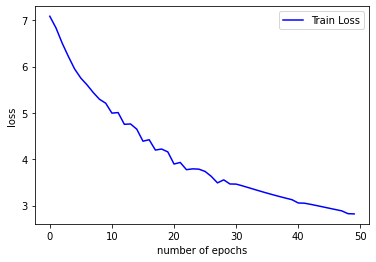

In [12]:
# inspired by https://jamesmccaffrey.wordpress.com/2020/05/22/a-minimal-pytorch-complete-example/

import numpy as np
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

device = T.device("cpu")  # apply to Tensor or Module

# -----------------------------------------------------------

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hid1 = T.nn.Linear(4, 7)  
    self.oupt = T.nn.Linear(7, 3)
    # (initialize weights)

  def forward(self, x):
    z = F.relu(self.hid1(x))
    z = self.oupt(z)  # no softmax. see CrossEntropyLoss() 
    return z

# -----------------------------------------------------------

def main():
  # 0. get started
  print("\nBegin minimal PyTorch Iris demo ")
  T.manual_seed(1)
  np.random.seed(1)
  
  # 1. set up training data
  print("\nLoading Iris train data ")

  train_x = np.array([
    [5.0, 3.5, 1.3, 0.3],
    [4.5, 2.3, 1.3, 0.3],
    [5.5, 2.6, 4.4, 1.2],
    [6.1, 3.0, 4.6, 1.4],
    [6.7, 3.1, 5.6, 2.4],
    [6.9, 3.1, 5.1, 2.3]], dtype=np.float32) 

  train_y = np.array([0, 0, 1, 1, 2, 2], dtype=np.long)

  print("\nTraining predictors:")
  print(train_x)
  print("\nTraining class labels: ")
  print(train_y)

  train_x = T.tensor(train_x, dtype=T.float32).to(device)
  train_y = T.tensor(train_y, dtype=T.long).to(device)

  # 2. create network
  net = Net().to(device)

  # 3. train model
  max_epochs = 50
  lrn_rate = 0.04
  loss_func = T.nn.CrossEntropyLoss()  # applies softmax()
  optimizer = T.optim.SGD(net.parameters(), lr=lrn_rate)

  print("\nStarting training ")
  net.train()

  train_losses = []
  for epoch in range(0, max_epochs):
    epoch_loss = 0
    for i in range(0, 6):
      X = train_x[i].reshape(1, 4)  # device inherited
      Y = train_y[i].reshape(1,)

      optimizer.zero_grad()
      oupt = net(X)

      loss = loss_func(oupt, Y)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    train_losses.append(epoch_loss)
    
    print(f"Loss in epoch {epoch+1} is {epoch_loss}")
  
  print("Done training ")

  fig = plt.figure()
  plt.plot(range(0, max_epochs), train_losses, color='blue')
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel('number of epochs')
  plt.ylabel('loss')

  # 4. (evaluate model accuracy)
  

  # 5. use model to make a prediction
  net.eval()
  print("\nPredicting species for [5.8, 2.8, 4.5, 1.3]: ")
  unk = np.array([[5.8, 2.8, 4.5, 1.3]], dtype=np.float32)
  unk = T.tensor(unk, dtype=T.float32).to(device) 
  logits = net(unk).to(device)
  probs = T.softmax(logits, dim=1)
  probs = probs.detach().numpy()  # allows printoptions

  np.set_printoptions(precision=4)
  print(probs)

  print("\nEnd Iris demo")

if __name__ == "__main__":
  main()